# Exploración de datos satelitales del 15 de Febrero de 1997
## Yuritzy Pérez 11/11/2023

#### Importar librerías

In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

#### Carga datos de SSH

In [2]:
data=xr.open_dataset('dt_global_allsat_phy_l4_19970215_20210726.nc')
data

<xarray.Dataset>
Dimensions:         (time: 1, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * time            (time) datetime64[ns] 1997-02-15
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
Data variables: (12/14)
    crs             int32 ...
    lat_bnds        (latitude, nv) float32 ...
    lon_bnds        (longitude, nv) float32 ...
    sla             (time, latitude, longitude) float64 ...
    err_sla         (time, latitude, longitude) float64 ...
    ugosa           (time, latitude, longitude) float64 ...
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 ...
    adt             (time, latitude, longitude) float64 ...
    ugos            (time, latitude, longitude) float64 ...
    vgos            (time, latitude, longitude) float64 ...
    flag_ice        (time, latitude, longitude) float64 ...
    tpa_correction  (time) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1997-02-15T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1997-02-14T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

#### Graficos de las variables

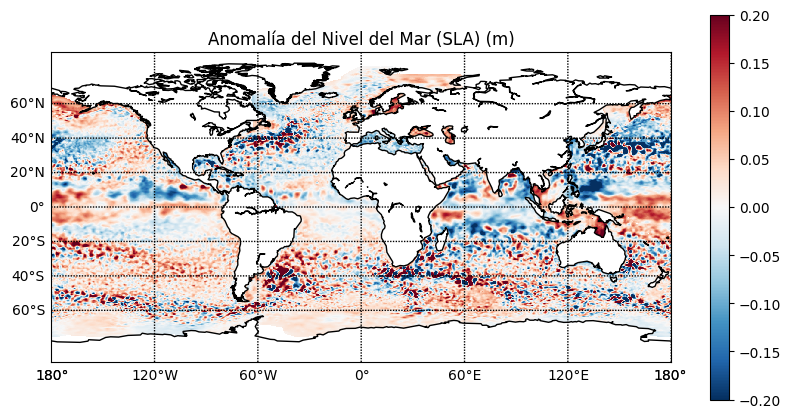

In [3]:
# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Crea un mapa base con proyección PlateCarree
m = Basemap(projection='cyl', resolution='c', ax=ax)

# Agrega las características del mundo
m.drawcoastlines(color='black')

# Grafica la vorticidad
im = m.pcolormesh(data['longitude'], data['latitude'],  data['sla'][0, :, :], vmax=0.2, vmin=-0.2, cmap='RdBu_r', rasterized=True)

# Configura etiquetas y título
ax.set_title('Anomalía del Nivel del Mar (SLA) (m)')

m.drawparallels(range(-60, 61, 20), labels=[1,0,0,0])  # Números a los paralelos
m.drawmeridians(range(-180, 181, 60), labels=[0,0,0,1])  # Números a los meridianos

# Agrega la barra de color
fig.colorbar(im)

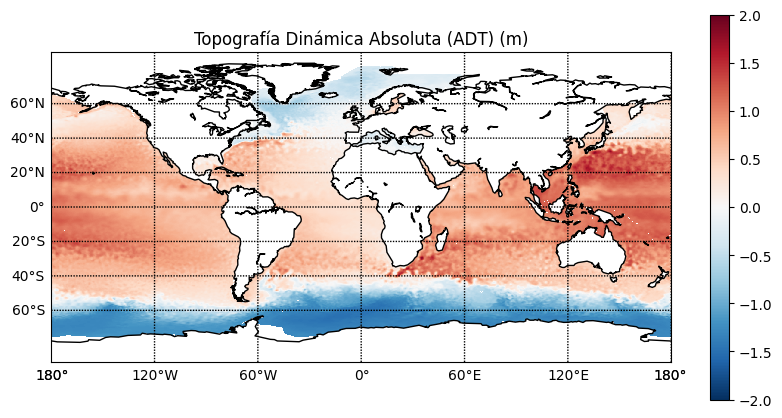

In [4]:
# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Crea un mapa base con proyección PlateCarree
m = Basemap(projection='cyl', resolution='c', ax=ax)

# Agrega las características del mundo
m.drawcoastlines(color='black')

# Grafica la vorticidad
im = m.pcolormesh(data['longitude'], data['latitude'],  data['adt'][0, :, :], vmax=2, vmin=-2, cmap='RdBu_r', rasterized=True)

# Configura etiquetas y título
ax.set_title('Topografía Dinámica Absoluta (ADT) (m)')

m.drawparallels(range(-60, 61, 20), labels=[1,0,0,0])  # Números a los paralelos
m.drawmeridians(range(-180, 181, 60), labels=[0,0,0,1])  # Números a los meridianos

# Agrega la barra de color
fig.colorbar(im)


Submuestreamos las corrientes para que se observen en el gráfico

In [5]:
# Submuestrea las corrientes
subsample_factor = 10
lon_subsampled = data['longitude'][::subsample_factor]
lat_subsampled = data['latitude'][::subsample_factor]
ugos_subsampled = data['ugos'].values[0,::subsample_factor, ::subsample_factor]
vgos_subsampled = data['vgos'].values[0,::subsample_factor, ::subsample_factor]

In [6]:
ugos_subsampled.shape

(72, 144)

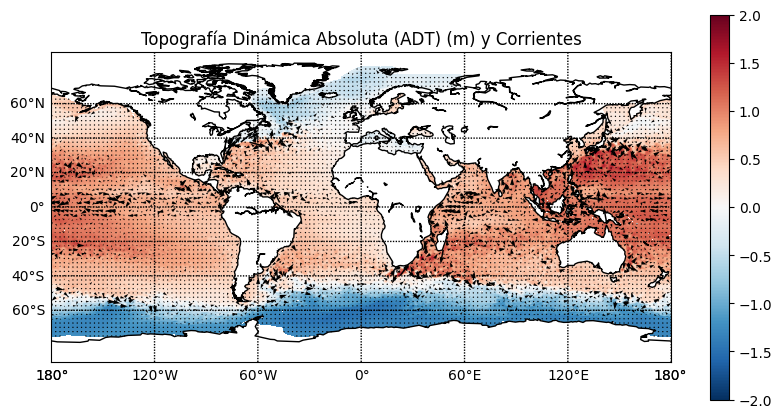

In [7]:
# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Crea un mapa base con proyección PlateCarree
m = Basemap(projection='cyl', resolution='c', ax=ax)

# Agrega las características del mundo
m.drawcoastlines(color='black')

# Grafica la vorticidad
im = m.pcolormesh(data['longitude'], data['latitude'],  data['adt'][0, :, :], vmax=2, vmin=-2, cmap='RdBu_r', rasterized=True)

m.drawparallels(range(-60, 61, 20), labels=[1,0,0,0])  # Números a los paralelos
m.drawmeridians(range(-180, 181, 60), labels=[0,0,0,1])  # Números a los meridianos

# Agrega la barra de color
fig.colorbar(im)

# Agrega el gráfico de corrientes con quiver
# Asegúrate de que lon_subsampled y lat_subsampled sean matrices 2D
lon_subsampled_2d, lat_subsampled_2d = np.meshgrid(lon_subsampled, lat_subsampled)

quiver_scale = 50  # Ajusta el tamaño de las flechas según sea necesario
# Ajusta la llamada a quiver
ax.quiver(lon_subsampled_2d, lat_subsampled_2d, ugos_subsampled, vgos_subsampled, scale=quiver_scale)


plt.title('Topografía Dinámica Absoluta (ADT) (m) y Corrientes')
plt.show()

#### Calcula la vorticidad 

In [8]:
# Calcular las derivadas utilizando xarray
du_dy = xr.apply_ufunc(np.gradient, data['ugos'], input_core_dims=[['latitude']], output_core_dims=[['latitude']],
                       vectorize=True, dask='parallelized')
dv_dx = xr.apply_ufunc(np.gradient, data['vgos'], input_core_dims=[['longitude']], output_core_dims=[['longitude']],
                       vectorize=True, dask='parallelized')

# Calcular la vorticidad relativa
vorticidad = dv_dx - du_dy

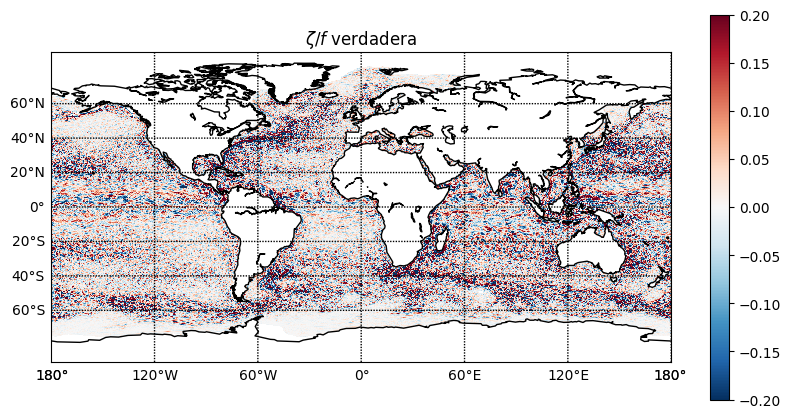

In [9]:
# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Crea un mapa base con proyección PlateCarree
m = Basemap(projection='cyl', resolution='c', ax=ax)

# Agrega las características del mundo
m.drawcoastlines(color='black')


# Grafica la vorticidad
im = m.pcolormesh(data['longitude'], data['latitude'], vorticidad[0, :, :], vmax=0.2, vmin=-0.2, cmap='RdBu_r', rasterized=True)

# Configura etiquetas y título
ax.set_title('$\zeta/f$ verdadera')

m.drawparallels(range(-60, 61, 20), labels=[1,0,0,0])  # Números a los paralelos
m.drawmeridians(range(-180, 181, 60), labels=[0,0,0,1])  # Números a los meridianos

# Agrega la barra de color
fig.colorbar(im)

# Guarda la figura
plt.savefig("RV_versatilite.pdf", bbox_inches="tight")

# Muestra la figura
plt.show()



#### Calcula la divergencia

In [10]:
# Calcular las derivadas utilizando xarray
du_dx = xr.apply_ufunc(np.gradient, data['ugos'], input_core_dims=[['longitude']], output_core_dims=[['longitude']],
                       vectorize=True, dask='parallelized')
dv_dy = xr.apply_ufunc(np.gradient, data['vgos'], input_core_dims=[['latitude']], output_core_dims=[['latitude']],
                       vectorize=True, dask='parallelized')

# Calcular la vorticidad relativa
divergencia = du_dx + dv_dy

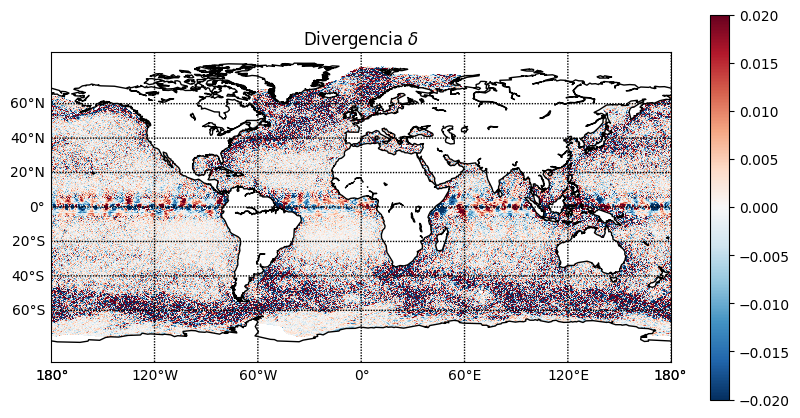

In [11]:
# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Crea un mapa base con proyección PlateCarree
m = Basemap(projection='cyl', resolution='c', ax=ax)

# Agrega las características del mundo
m.drawcoastlines(color='black')


# Grafica la vorticidad
im = m.pcolormesh(data['longitude'], data['latitude'], divergencia[0, :, :], vmax=0.02, vmin=-0.02, cmap='RdBu_r', rasterized=True)

# Configura etiquetas y título
ax.set_title('Divergencia $\delta$ ')

m.drawparallels(range(-60, 61, 20), labels=[1,0,0,0])  # Números a los paralelos
m.drawmeridians(range(-180, 181, 60), labels=[0,0,0,1])  # Números a los meridianos

# Agrega la barra de color
fig.colorbar(im)

# Guarda la figura
#plt.savefig("RV_versatilite.pdf", bbox_inches="tight")

# Muestra la figura
plt.show()



#### Calcula el strain

In [12]:
strain = np.sqrt((du_dx-dv_dy)**2+(dv_dx+du_dy)**2)

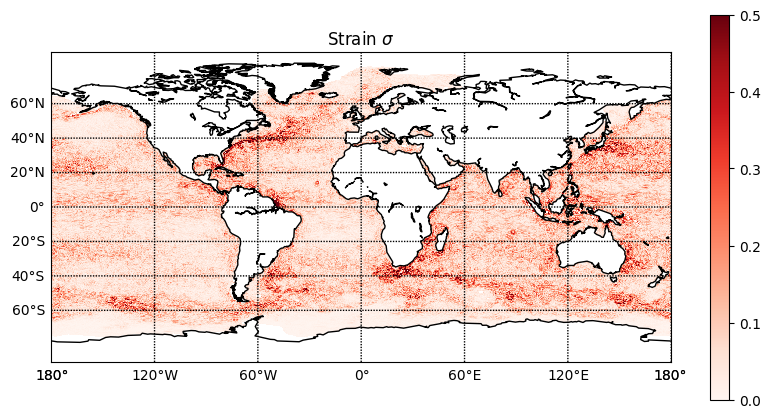

In [13]:
# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 5))

# Crea un mapa base con proyección PlateCarree
m = Basemap(projection='cyl', resolution='c', ax=ax)

# Agrega las características del mundo
m.drawcoastlines(color='black')


# Grafica la vorticidad
im = m.pcolormesh(data['longitude'], data['latitude'], strain[0, :, :], vmax=0.5, vmin=0, cmap='Reds', rasterized=True)

# Configura etiquetas y título
ax.set_title('Strain $\sigma$')

m.drawparallels(range(-60, 61, 20), labels=[1,0,0,0])  # Números a los paralelos
m.drawmeridians(range(-180, 181, 60), labels=[0,0,0,1])  # Números a los meridianos

# Agrega la barra de color
fig.colorbar(im)


# Muestra la figura
plt.show()